# LSTM Model Explainability


In [96]:
import sys
sys.path.append('..')

In [97]:
import numpy as np
import pandas as pd
import random
import shap

from lib.township_range import TownshipRanges
from lib.read_data import read_and_join_output_file
from lib.deeplearning import get_train_test_datasets, get_sets_shapes, get_data_for_prediction, evaluate_forecast, combine_all_target_years, get_year_to_year_differences, get_train_test_datasets_with_2021_as_target
from lib.viz import view_trs_side_by_side, draw_hyperparameters_distribution, draw_line_chart

import tensorflow
from tensorflow import keras

## Loading the Data and LSTM Model
We load the dataset and the best LSTM model

In [100]:
test_size=0.15
target_variable="GSE_GWE"
# Load the data from the ETL output files
X = read_and_join_output_file()
X.drop(["SHORTAGE_COUNT"], inplace=True, axis=1)
# Split the input pandas Dataframe into training and test datasets, applies the impute pipeline
# transformation and reshapes the datasets to 3D (samples, time, features) numpy arrays
X_train, X_test, y_train, y_test, impute_pipeline, impute_columns, target_scaler = get_train_test_datasets(X, target_variable=target_variable, test_size=test_size, random_seed=RANDOM_SEED, save_to_file=True)
model_predictions_df = pd.DataFrame(y_test, columns=[target_variable])
model_scores_df = pd.DataFrame(columns=["MAE", "MSE", "RMSE"])
nb_features = X_train.shape[-1]
get_sets_shapes(X_train, X_test)

,nb_items,nb_timestamps,nb_features
training dataset,406,7,80
test dataset,72,7,80


In [101]:
model = keras.models.load_model("../assets/models/keras_lstm_model")

## Initializing SHAP
We use the SHAP library to compute the SHAP value based on the Township-Ranges in the training data

In [102]:
tensorflow.compat.v1.disable_v2_behavior()
shap.initjs()

In [103]:
# DeepExplainer to explain predictions of the model
lstm_explainer = shap.DeepExplainer(model, X_train)
# compute shap values
lstm_shap_values = lstm_explainer.shap_values(X_test)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [104]:
lstm_shap_values[0]

array([[[ 1.04135847e-05, -6.46342573e-05, -6.57805982e-04, ...,
          5.43952939e-05, -2.55627918e-06,  5.67650508e-06],
        [ 4.99845017e-05, -1.02566344e-04, -1.02556091e-03, ...,
          1.32331446e-04, -3.69049502e-06,  9.40184065e-06],
        [ 1.04017996e-04, -1.16659780e-04,  6.60306545e-04, ...,
          2.23569283e-05, -1.15585191e-05,  2.39188090e-06],
        ...,
        [ 4.54027809e-04, -8.68611937e-05, -1.37616171e-03, ...,
          1.25035515e-04, -4.56155871e-06, -7.09674808e-06],
        [ 8.28232827e-04, -9.98178227e-05, -2.03985388e-03, ...,
          2.37969461e-04,  3.69809207e-05, -1.64941895e-05],
        [-6.28600106e-04,  3.40685343e-04, -3.30797416e-03, ...,
          7.93512492e-04, -4.99892454e-04,  9.78154697e-04]],

       [[ 1.03288452e-05, -6.29681972e-05, -5.10138592e-04, ...,
          5.38273118e-05, -2.56057555e-06,  5.74689789e-06],
        [-1.20842718e-04, -5.86913372e-05, -5.83262266e-04, ...,
          3.13484329e-05, -3.69735597e

## SHAP Global Interpretation
In the case of an LSTM model with test data of the format 72\ TownshipRanges\ *\ 7\ time stamps\ *\ 80\ features$ the SHAP values are also of the same format. SHAP thus computes SHAP values for each feature of each year.
### 2014 Most Important Features

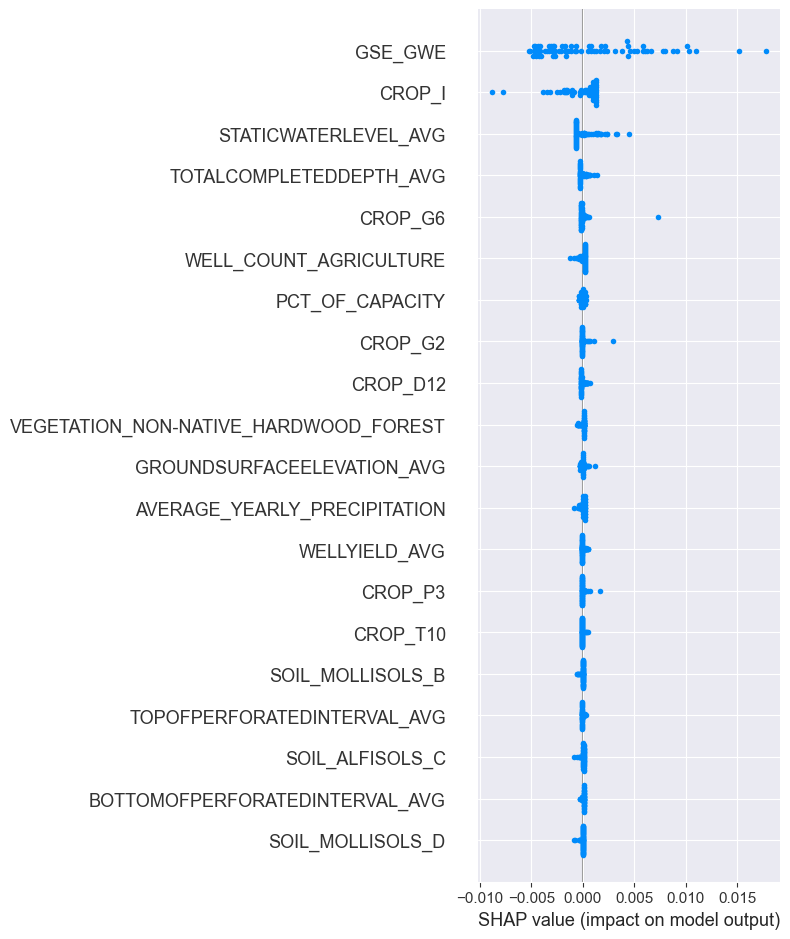

In [105]:
shap.summary_plot(lstm_shap_values[0][:,0,:], feature_names=impute_columns)

### 2015 Most Important Features

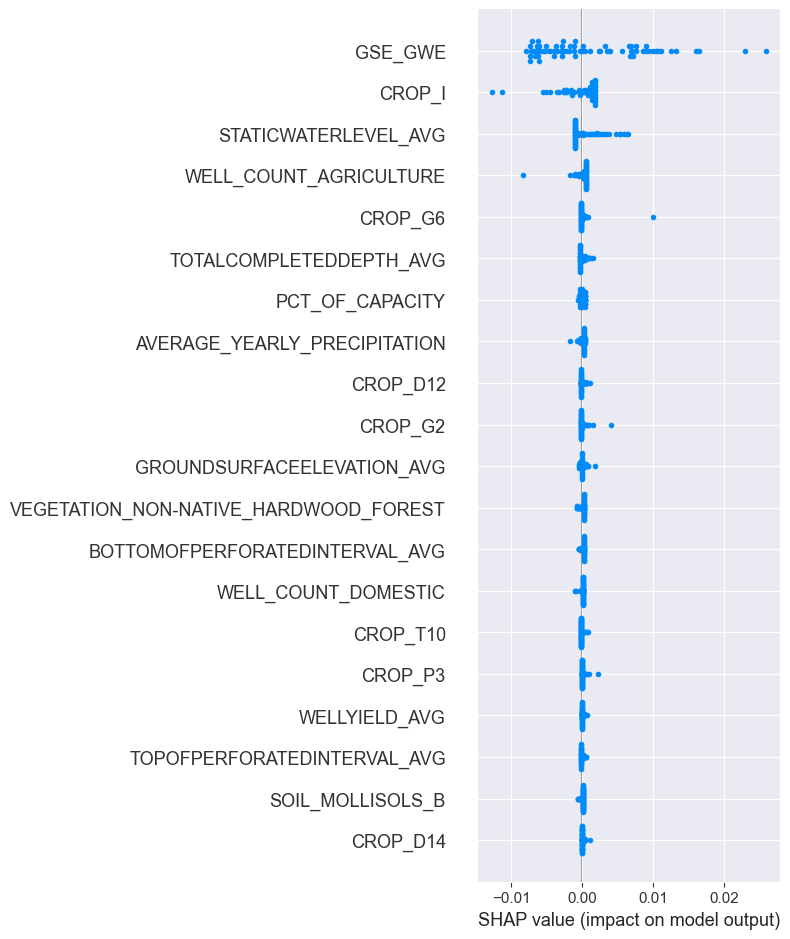

In [106]:
shap.summary_plot(lstm_shap_values[0][:,1,:], feature_names=impute_columns)

### 2016 Most Important Features

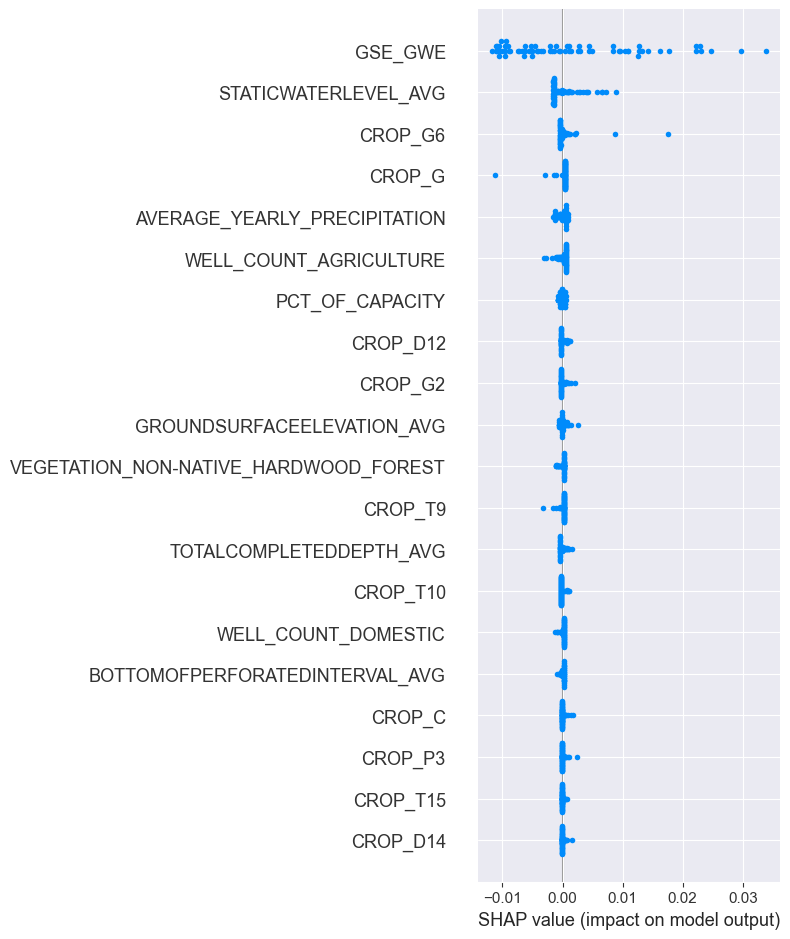

In [107]:
shap.summary_plot(lstm_shap_values[0][:,2,:], feature_names=impute_columns)

### 2017 Most Important Features

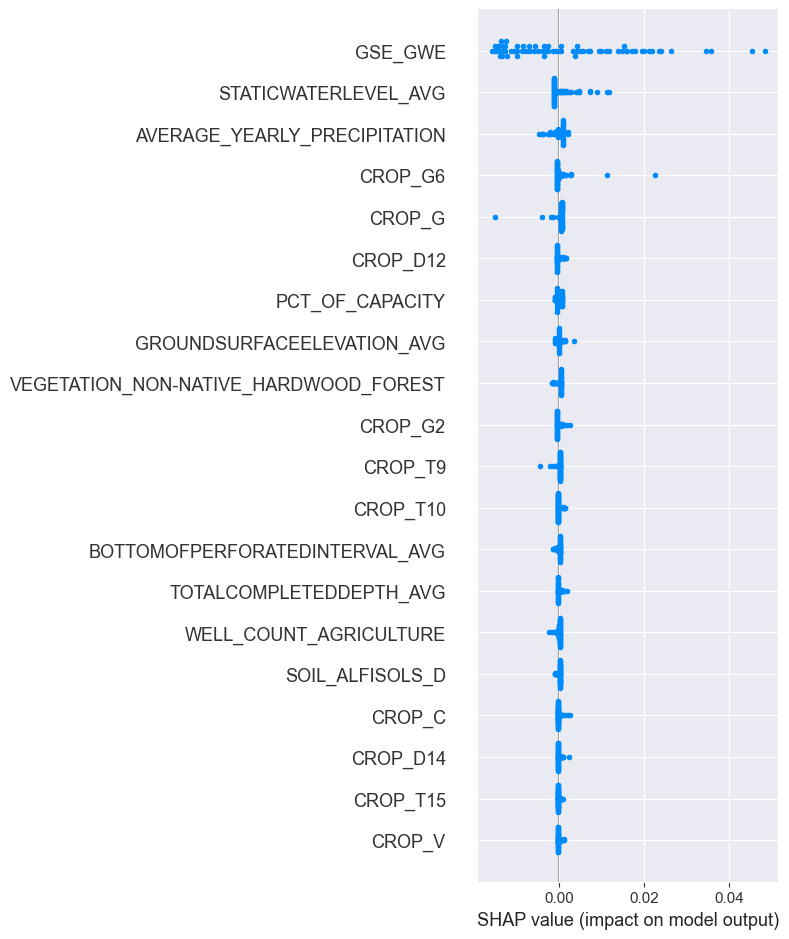

In [108]:
shap.summary_plot(lstm_shap_values[0][:,3,:], feature_names=impute_columns)

### 2018 Most Important Features

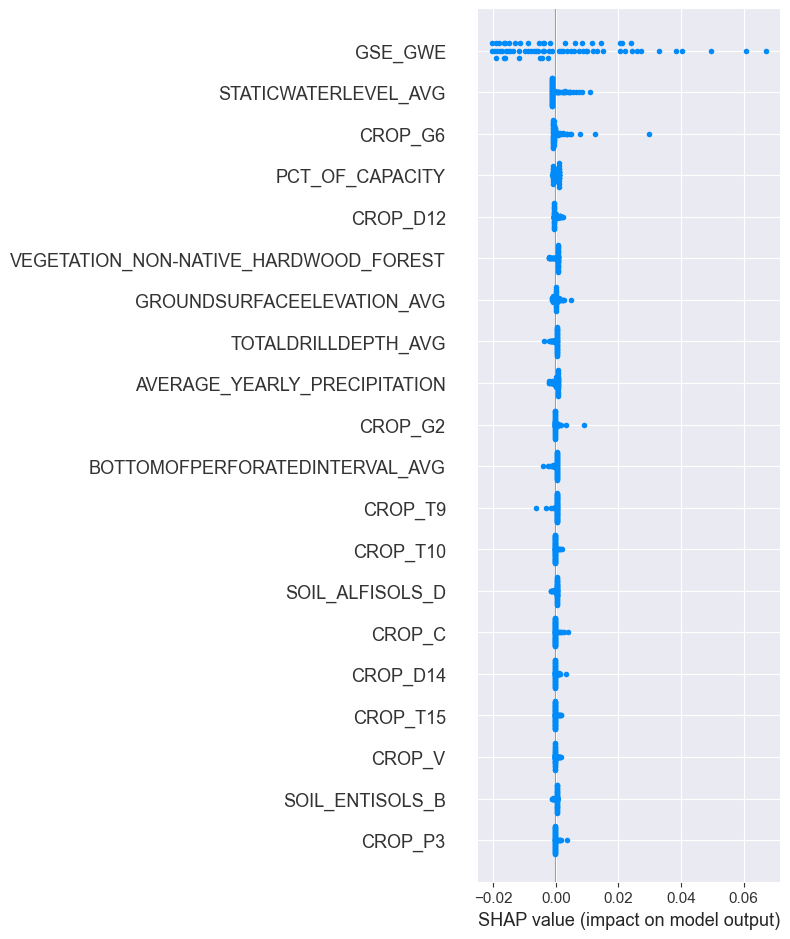

In [109]:
shap.summary_plot(lstm_shap_values[0][:,4,:], feature_names=impute_columns)

### 2019 Most Important Features

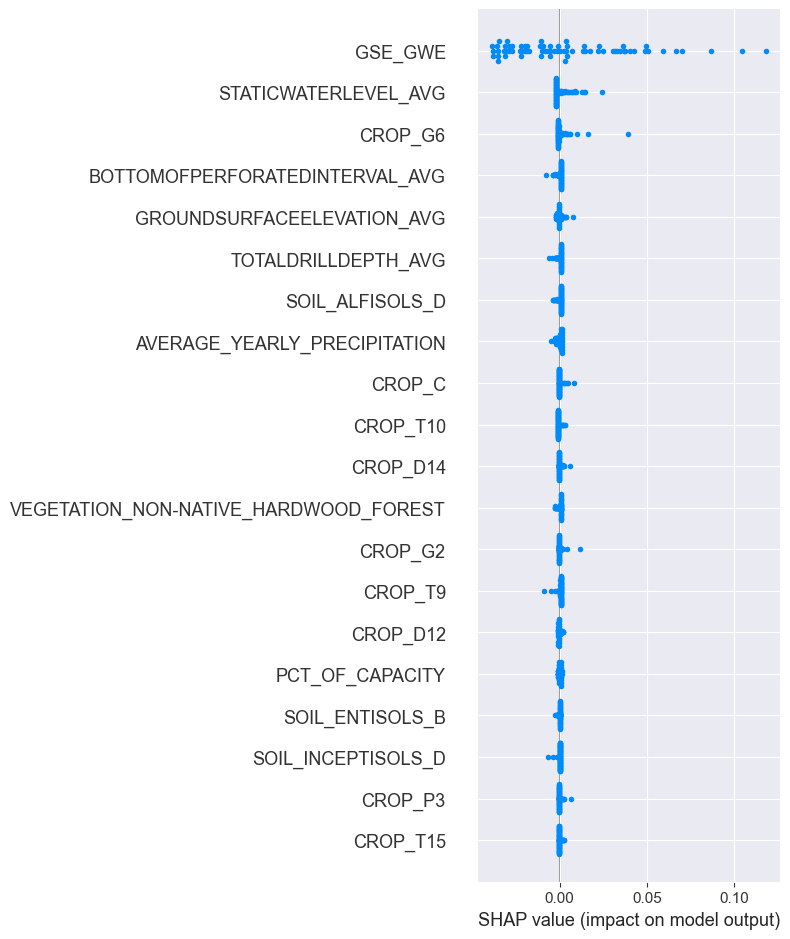

In [110]:
shap.summary_plot(lstm_shap_values[0][:,5,:], feature_names=impute_columns)

### 2020 Most Important Features

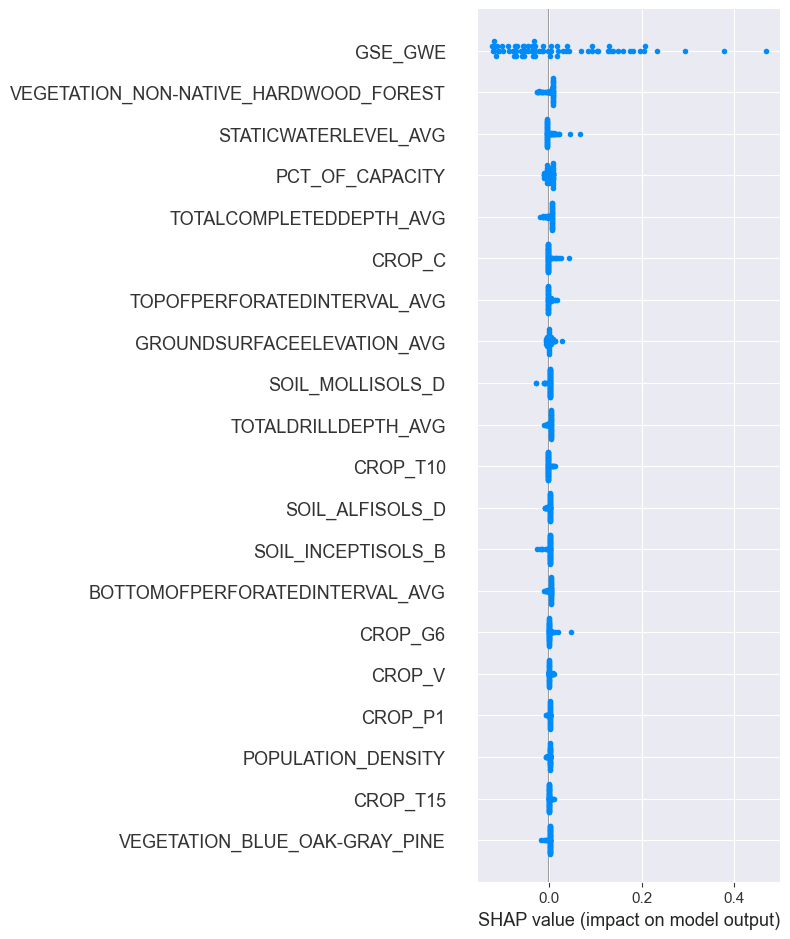

In [111]:
shap.summary_plot(lstm_shap_values[0][:,6,:], feature_names=impute_columns)

Looking at the top 5 features of each year, we can see that the important features explaining the predictions vary from year to year with the following trends:
* Like for machine learning models, the past `GSE_GWE` remain the best predicator for the 2021 predictions of the `GSE_GWE`of the LSTM model.
* The `STATICWATERLEVEL_AVG` (the distance from the land surface (or the measuring point) to the water in a well under non-pumping (static) conditions) is consitantly the second or third most important feature throughout all the years
* In the early years the `CROP_I` (idle, meaning there is no crops being raised on the farming land) and `TOTALCOMPLETEDDEPTH_AVG`
* From 2016 to 2018 the `AVERAGE_YEARLY_PRECIPITATION` plays an important role
* From 2016 to 2019 the crop `CROP_G6` (miscellaneous grain and hay) remains one of the main features explaining the predictions
* Only in 2019 are well measures `BOTTOMPERFORATEDINTERVAL_AVG` and `GROUNDSURFACEELEVATION_AVG` part of the top 5 most important features
* Like for the Random Forest and Support Vector Regression (SVR) models, the `VEGETATION_NON-NATIVE_HARDWOOD_FOREST` is the second most important features
* Soil features seem to globally have very little importance in the explainability of the model predictions



## SHAP Local Interpretation

In [125]:
shap.force_plot(lstm_explainer.expected_value[0], lstm_shap_values[0][0], features = impute_columns)


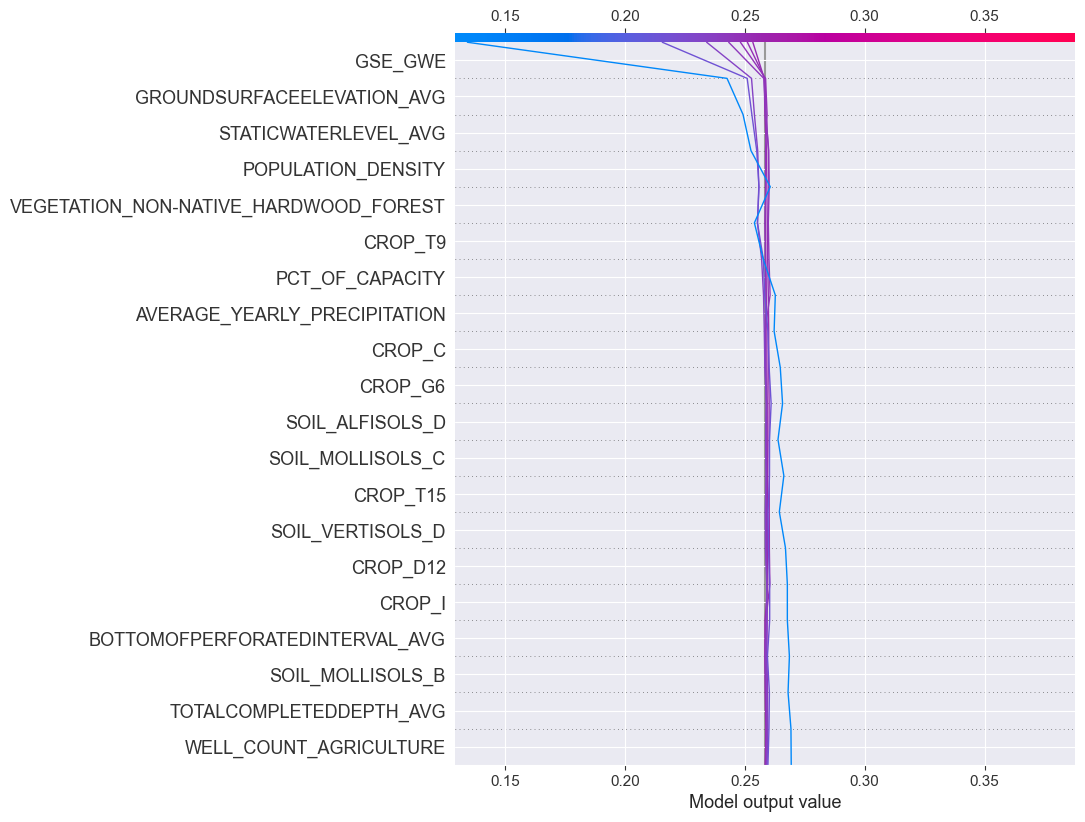

In [130]:
shap.decision_plot(lstm_explainer.expected_value[0], lstm_shap_values[0][0], feature_names = impute_columns)